In [1]:
# for GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# import dependencies
import gym
import numpy as np
import tensorflow as tf
import random
from collections import deque # special kind of list
import matplotlib.pyplot as plt
import time                   

In [2]:
print(tf.__version__)

1.15.0


# BREAKOUT

In [11]:
# network structure parameters
env = gym.make('Breakout-v0')

input_height = 80
input_width = 80
###################
stack = 4
###################
action_size = 2

# learning parameters
learning_rate = 0.001
momentum = 0.95

eps_min = 0.1
eps_max = 1
eps_decay_steps = 2000000

# training parameters
n_steps = 4000000 
training_start = 10000 
training_interval = 4 
save_steps = 1000 
copy_steps = 10000
discount_rate = 0.95
skip_start = 30 # skip the start of every game
batch_size = 50
iteration = 0 # game iteration
checkpoint_path = './Model1/my_dqn_break_p1.ckpt'
done = True # env needs to be reset

Right_action = 2
Left_action = 3
action_dict = {0: Right_action, 1: Left_action}
action_dict

{0: 2, 1: 3}

In [4]:
stack_frame = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack)], maxlen = 4)
def stacked_frames(stack_frame, state, is_new_episode):
    frame = preprocess(state)
    if is_new_episode:
        stack_frame = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack)], maxlen = 4)
        
        stack_frame.append(frame)
        stack_frame.append(frame)
        stack_frame.append(frame)
        stack_frame.append(frame)
        
        stack_state = np.stack(stack_frame, axis = 2)
    else:
        stack_frame.append(frame)
        stack_state = np.stack(stack_frame, axis = 2)
        
    return stack_state, stack_frame


In [5]:
# preprocess the date

def preprocess(image):
    image = image[35:195] 
    image = image[::2,::2,0]
    image[image == 144] = 0 
    image[image == 109] = 0 
    image[image != 0] = 1 
    return np.reshape(image.astype(np.float).ravel(), [80,80])

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape = maxlen, dtype = np.object)
        self.index = 0
        self.length = 0
    
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length +1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
        
    def sample(self, batch_size, with_replacement = True):
        indices = np.random.randint(self.length, size = batch_size)
        return self.buf[indices]
           

In [14]:
def DQ_network(X_state, action_size, name):

    input_layer = X_state/128.0
    with tf.variable_scope(name) as scope:
        with tf.name_scope('conv1'):
            conv_layer1 = tf.layers.conv2d(input_layer, filters = 32, kernel_size = (8,8),
                                         strides = 4, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
    
        with tf.name_scope('conv2'):
            conv_layer2 = tf.layers.conv2d(conv_layer1, filters = 64, kernel_size = (4,4),
                                         strides = 2, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        with tf.name_scope('conv3'):
            conv_layer3 = tf.layers.conv2d(conv_layer2, filters = 64, kernel_size = (2,2),
                                         strides = 1, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            #flatten the last layer
            last_conv_layer_flat = tf.contrib.layers.flatten(conv_layer3) 
            
        with tf.name_scope('hidden'):
            hidden = tf.contrib.layers.fully_connected(last_conv_layer_flat, 512, 
                                     activation_fn = tf.nn.relu,
                                     weights_initializer = tf.contrib.layers.xavier_initializer())
            
        with tf.name_scope('output'):
            outputs = tf.layers.dense(hidden, action_size, kernel_initializer = tf.contrib.layers.xavier_initializer())
    
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    
    return outputs, trainable_vars_by_name



In [16]:
tf.reset_default_graph()
X_state = tf.placeholder(tf.float32, shape = [None, input_height, input_width, 4])
train_q_values, train_vars = DQ_network(X_state, action_size, name = 'train_networks')
target_q_values, target_vars = DQ_network(X_state, action_size, name = 'target_networks')

with tf.variable_scope('train'):
    X_action = tf.placeholder(tf.int32, shape = [None])
    y = tf.placeholder(tf.float32, shape = [None, 1])
    q_value = tf.reduce_sum(train_q_values * tf.one_hot(X_action, action_size),
                           axis = 1, keepdims = True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0,1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    
    global_step = tf.Variable(0, trainable = False, name = 'global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov = True)
    training_op = optimizer.minimize(loss, global_step = global_step)



In [ ]:
total_max_q = 0
game_length = 0

mean_q = []

init = tf.global_variables_initializer()
saver = tf.train.Saver()

copy_ops = [target_var.assign(train_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_train_to_target = tf.group(*copy_ops)

replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)



start = time.time()

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_train_to_target.run()
        
    while True:
        step = global_step.eval()
        iteration +=1

        if done:
            obs = env.reset()
            for skip in range(skip_start):
                obs, reward, done, info = env.step(0)
               
            #state = preprocess(obs)
            state, stack_frame = stacked_frames(stack_frame, obs, True)
            
        q_values = train_q_values.eval(feed_dict = {X_state: [state]})
        
        epsilon = max(eps_min, eps_max - (eps_max - eps_min)*step/eps_decay_steps)
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)  # random action
        else:
            action = np.argmax(q_values) # optimal action 
        

        obs, reward, done, info = env.step(action)
        next_state, stack_frame = stacked_frames(stack_frame, obs, True)
      
        
        # memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        # compute statistics for tracking progress
        total_max_q += q_values.max()
        game_length +=1
        
        if done: 
            mean_max_q = total_max_q/game_length
            mean_q.append(mean_max_q)
            total_max_q = 0.0
            game_length = 0
            
        if iteration < training_start or iteration % training_interval !=0:
            continue
        
        
        cols = [[],[],[],[],[]]
        for memory in replay_memory.sample(batch_size):
            for col, value in zip(cols, memory):
                col.append(value)
        cols = [np.array(col) for col in cols]
        X_state_val = cols[0]
        X_action_val = cols[1] 
        rewards = cols[2].reshape(-1,1)
        X_next_state_val = cols[3]
        continues = cols[4].reshape(-1,1)
        
        next_q_values = target_q_values.eval(feed_dict = {X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis = 1, keepdims = True)
        y_val = rewards + continues*discount_rate*max_next_q_values

        # train the train DQN
        _, loss_val = sess.run([training_op, loss], feed_dict = {X_state: X_state_val, X_action: X_action_val, y: y_val})
        
        # regularly copy the train DQN to the target DQN
        if step % copy_steps == 0:
            copy_train_to_target.run()
            
        if step % save_steps ==0:
            saver.save(sess, checkpoint_path)
            
              
        end = time.time()
        time_elapsed = end - start       
        print('\rIteration {}\tTraining step {} \tTime Elapsed {:2f} \tLoss {:5f}\tMean Max-Q {:5f}'.format(
        iteration, step, time_elapsed, loss_val, mean_max_q), end = '')
        # train 24 hours
        if time_elapsed > 86400:
            break


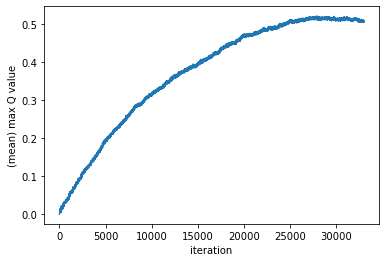

In [8]:

plt.plot(mean_q)
plt.xlabel('iteration')
plt.ylabel('(mean) max Q value')
plt.show()     

INFO:tensorflow:Restoring parameters from ./my_dqn_break.ckpt
Game number 999	total_reward 0.000000

Text(0, 0.5, 'total_rewards')

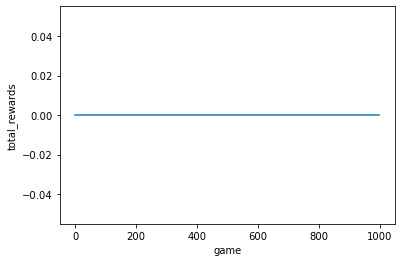

In [23]:
total_max_q = 0
game_length = 0

mean_q = []

init = tf.global_variables_initializer()
saver = tf.train.Saver()

iteration = 0
done = True
game_num = 0
total_rewards = []

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)    
    while True:

        if done:
            game_length = 0
            if iteration > 0:
                total_rewards.append(total_reward)
                game_num += 1
            if game_num >= 1000:
                break
            obs = env.reset()
            total_reward = 0
            obs, reward, done, info = env.step(0)
            total_reward += reward
            #state = preprocess(obs)
            state, stack_frame = stacked_frames(stack_frame, obs, True)
            #state = state.reshape(state.shape + (1,))

        iteration += 1

        q_values = train_q_values.eval(feed_dict = {X_state: [state]})

        action = np.argmax(q_values) # optimal action 

        obs, reward, done, info = env.step(action)
        state, stack_frame = stacked_frames(stack_frame, obs, True)
        #state = preprocess(obs)
        #state = state.reshape(state.shape + (1,))
        
        # compute statistics for tracking progress
        game_length +=1
        total_reward += reward

        print('\rGame number {}\ttotal_reward {:5f}'.format(game_num, total_reward), end = '')

        #print(mean_q, iteration)
plt.plot(range(game_num), total_rewards)
plt.xlabel('game')
plt.ylabel('total_rewards')        

# MsPacman-v0


In [25]:
# network structure parameters
env = gym.make('MsPacman-v0')

input_height = 88
input_width = 80
input_channels = 1

action_size = env.action_space.n

# learning parameters
learning_rate = 0.001
momentum = 0.95

eps_min = 0.1
eps_max = 1
eps_decay_steps = 2000000

# training parameters
n_steps = 4000000 # total number of training steps
training_start = 10000 # start training after 10000 game iterations
training_interval = 4 # run a training step every 4 game iterations/ episodes
save_steps = 10000 # save the model every 10000 training steps
copy_steps = 10000 # copy train DQN to target DQN every 10000 training steps
discount_rate = 0.99
skip_start = 90 # skip the start of every game
batch_size = 50
iteration = 0 # game iteration
checkpoint_path = './Model2/my_dqn.ckpt'
done = True # env needs to be reset

In [26]:
# preprocess the date
mspacman_color = 210+164+74

def preprocess_observation(obs):
   
    img = obs[1:176:2, ::2] 
    img = img.sum(axis=2) 
    img[img==mspacman_color] = 0 
    img = (img // 3 - 128).astype(np.int8) 
    return img.reshape(88, 80, 1)

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape = maxlen, dtype = np.object)
        self.index = 0
        self.length = 0
    
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length +1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
        
    def sample(self, batch_size, with_replacement = True):
        indices = np.random.randint(self.length, size = batch_size)
        return self.buf[indices]
           

In [27]:
def DQ_network(X_state, action_size, name):

    input_layer = X_state/128.0
    with tf.variable_scope(name) as scope:
        with tf.name_scope('conv1'):
            conv_layer1 = tf.layers.conv2d(input_layer, filters = 32, kernel_size = (8,8),
                                         strides = 4, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
    
        with tf.name_scope('conv2'):
            conv_layer2 = tf.layers.conv2d(conv_layer1, filters = 64, kernel_size = (4,4),
                                         strides = 2, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        with tf.name_scope('conv3'):
            conv_layer3 = tf.layers.conv2d(conv_layer2, filters = 64, kernel_size = (2,2),
                                         strides = 1, padding = 'SAME', activation = tf.nn.relu, 
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            #flatten the last layer
            last_conv_layer_flat = tf.contrib.layers.flatten(conv_layer3) 
            
        with tf.name_scope('hidden'):
            hidden = tf.contrib.layers.fully_connected(last_conv_layer_flat, 512, 
                                     activation_fn = tf.nn.relu,
                                     weights_initializer = tf.contrib.layers.xavier_initializer())
            
        with tf.name_scope('output'):
            outputs = tf.layers.dense(hidden, action_size, kernel_initializer = tf.contrib.layers.xavier_initializer())
    
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    
    return outputs, trainable_vars_by_name


In [28]:
tf.reset_default_graph()
X_state = tf.placeholder(tf.float32, shape = [None, input_height, input_width, input_channels])
train_q_values, train_vars = DQ_network(X_state, action_size, name = 'train_networks')
target_q_values, target_vars = DQ_network(X_state, action_size, name = 'target_networks')

with tf.variable_scope('train'):
    X_action = tf.placeholder(tf.int32, shape = [None])
    y = tf.placeholder(tf.float32, shape = [None, 1])
    q_value = tf.reduce_sum(train_q_values * tf.one_hot(X_action, action_size),
                           axis = 1, keepdims = True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0,1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    
    global_step = tf.Variable(0, trainable = False, name = 'global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov = True)
    training_op = optimizer.minimize(loss, global_step = global_step)


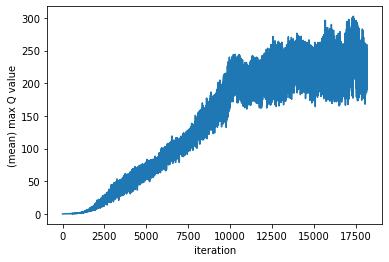

In [33]:
total_max_q = 0
game_length = 0

mean_q = []

init = tf.global_variables_initializer()
saver = tf.train.Saver()

copy_ops = [target_var.assign(train_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_train_to_target = tf.group(*copy_ops)

replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)



start = time.time()

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_train_to_target.run()
        
    while True:
        step = global_step.eval()
        iteration +=1

        if done:
            obs = env.reset()
            for skip in range(skip_start):
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
            
        q_values = train_q_values.eval(feed_dict = {X_state: [state]})
        
        epsilon = max(eps_min, eps_max - (eps_max - eps_min)*step/eps_decay_steps)
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)  # random action
        else:
            action = np.argmax(q_values) # optimal action 

        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        # compute statistics for tracking progress
        total_max_q += q_values.max()
        game_length +=1
        
        if done: 
            mean_max_q = total_max_q/game_length
            mean_q.append(mean_max_q)
            total_max_q = 0.0
            game_length = 0
            
        if iteration < training_start or iteration % training_interval !=0:
            continue
        
        
        cols = [[],[],[],[],[]]
        for memory in replay_memory.sample(batch_size):
            for col, value in zip(cols, memory):
                col.append(value)
        cols = [np.array(col) for col in cols]
        X_state_val = cols[0]
        X_action_val = cols[1] 
        rewards = cols[2].reshape(-1,1)
        X_next_state_val = cols[3]
        continues = cols[4].reshape(-1,1)
        
        next_q_values = target_q_values.eval(feed_dict = {X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis = 1, keepdims = True)
        y_val = rewards + continues*discount_rate*max_next_q_values

        # train the train DQN
        _, loss_val = sess.run([training_op, loss], feed_dict = {X_state: X_state_val, X_action: X_action_val, y: y_val})
        
        # regularly copy the train DQN to the target DQN
        if step % copy_steps == 0:
            copy_train_to_target.run()
            
        if step % save_steps ==0:
            saver.save(sess, checkpoint_path)
                
        end = time.time()
        time_elapsed = end - start       
        print('\rIteration {}\tTraining step {} \tTime Elapsed {:2f} \tLoss {:5f}\tMean Max-Q {:5f}'.format(
        iteration, step, time_elapsed, loss_val, mean_max_q), end = '')
        
        if time_elapsed > 86400:
            break


plt.plot(mean_q)
plt.xlabel('iteration')
plt.ylabel('(mean) max Q value')
plt.show()        

Text(0, 0.5, 'total_rewards')

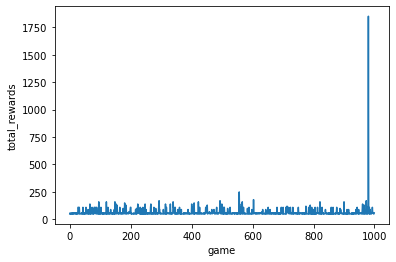

In [47]:
game_length = 0

init = tf.global_variables_initializer()
saver = tf.train.Saver()

iteration = 0
done = True
game_num = 0
total_rewards = []

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)    
    while True:

        if done:
            game_length = 0
            if iteration > 0:
                total_rewards.append(total_reward)
                game_num += 1
            if game_num >= 1000:
                break
            obs = env.reset()
            total_reward = 0
            obs, reward, done, info = env.step(0)
            total_reward += reward
            state = preprocess_observation(obs)

        iteration += 1

        q_values = train_q_values.eval(feed_dict = {X_state: [state]})

        action = np.argmax(q_values) # optimal action 

        obs, reward, done, info = env.step(action)
        state = preprocess_observation(obs)

        # compute statistics for tracking progress
        game_length +=1
        total_reward += reward

        
plt.plot(range(game_num), total_rewards)
plt.xlabel('game')
plt.ylabel('total_rewards')   